In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").appName("MPC").getOrCreate()
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/21 09:18:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
n = 20
m = 20
max_weight = 10

import networkx as nx
from random import randrange

# create a random graph
vertices = range(n)
edges = [(randrange(n), randrange(n), randrange(max_weight)) for _ in range(m)]

def save_graph(G, filename='graph.txt'):
    # persist to file
    nx.write_adjlist(G, file)

def load_graph(filename='graph.txt'):
    # read from file
    return nx.read_adjlist(filename)

In [6]:
import matplotlib.pyplot as plt

def draw_edges(vertices, edges, color_map, ax):
    G = nx.Graph() # empty graph
    G.add_nodes_from(vertices)
    G.add_weighted_edges_from(edges)

    # uses a force-directed simulation, better for large graphs
    pos = nx.spring_layout(G, k=1, iterations=10)

    # positions the nodes deterministically in ccw order, which is pretty nice for toy graphs
    #pos = nx.shell_layout(G)

    labels = nx.get_edge_attributes(G, 'weight')

    nx.draw(G, pos, ax, node_color=color_map, with_labels=True);
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=labels);

In [9]:
G = nx.Graph() # empty graph
G.add_nodes_from(vertices)
G.add_weighted_edges_from(edges)


# access the adjaceny list of G
for n in G:
    print(str(n) + ": " + str(G[n]))

0: {4: {'weight': 7}, 9: {'weight': 8}}
1: {5: {'weight': 5}, 6: {'weight': 4}, 14: {'weight': 9}, 12: {'weight': 4}}
2: {18: {'weight': 3}, 7: {'weight': 4}, 16: {'weight': 7}, 15: {'weight': 1}}
3: {8: {'weight': 8}, 13: {'weight': 0}}
4: {18: {'weight': 0}, 0: {'weight': 7}, 19: {'weight': 1}}
5: {1: {'weight': 5}}
6: {14: {'weight': 7}, 1: {'weight': 4}}
7: {10: {'weight': 3}, 2: {'weight': 4}}
8: {3: {'weight': 8}}
9: {0: {'weight': 8}}
10: {7: {'weight': 3}}
11: {}
12: {18: {'weight': 9}, 1: {'weight': 4}}
13: {13: {'weight': 8}, 3: {'weight': 0}}
14: {6: {'weight': 7}, 14: {'weight': 9}, 1: {'weight': 9}}
15: {2: {'weight': 1}}
16: {2: {'weight': 7}}
17: {}
18: {12: {'weight': 9}, 2: {'weight': 3}, 4: {'weight': 0}}
19: {4: {'weight': 1}}


In [10]:
def nearest_neighbor(adj_item):
    """Compute the nearest neighbor, if it exists, based on weights."""
    
    # TODO: can this be done more elegantly?
    u = adj_item[0]
    ngbs = adj_item[1]
    
    if len(ngbs) == 0:
        return u, u
    else:
        nn = min(ngbs, key=lambda x: x[1])
        return u, nn[0]

In [11]:
def contract_map(nn_br):
    # get the broadcasted value
    nn = nn_br.value

    def inner(adj_item):
        """Compute the label for each (u, ngbs) pair."""

        # TODO: can this be done more elegantly?
        u = adj_item[0]
        ngbs = adj_item[1]

        c = u
        v = u
        S = set()
        while v not in S:
            S.add(v)
            c = v
            v = nn[v]

        label = min(c, v)

        return label, (u, ngbs)

    return inner

In [12]:
# create a rdd for the adjancency list
adj = sc.parallelize(G.adj.items())

adj = adj.map(lambda z: (z[0], [(v, w['weight']) for v,w in z[1].items()]))
adj.collect()

[(0, [(4, 7), (9, 8)]),
 (1, [(5, 5), (6, 4), (14, 9), (12, 4)]),
 (2, [(18, 3), (7, 4), (16, 7), (15, 1)]),
 (3, [(8, 8), (13, 0)]),
 (4, [(18, 0), (0, 7), (19, 1)]),
 (5, [(1, 5)]),
 (6, [(14, 7), (1, 4)]),
 (7, [(10, 3), (2, 4)]),
 (8, [(3, 8)]),
 (9, [(0, 8)]),
 (10, [(7, 3)]),
 (11, []),
 (12, [(18, 9), (1, 4)]),
 (13, [(13, 8), (3, 0)]),
 (14, [(6, 7), (14, 9), (1, 9)]),
 (15, [(2, 1)]),
 (16, [(2, 7)]),
 (17, []),
 (18, [(12, 9), (2, 3), (4, 0)]),
 (19, [(4, 1)])]

In [270]:
# compute the nearest_neighbor mapping
nn_local = dict(adj.map(nearest_neighbor).collect())

# broadcast the closest neighbor mapping
nn = sc.broadcast(nn_local)

In [271]:
# compute labeling = { <label, <u, N(u)>> }
# where N(u) = { <u, v, weight> }
labeling = adj.map(contract_map(nn))
#labeling.collect()

In [272]:
# compute L = { <u, label> }
L_local = dict(labeling.map(lambda z: (z[1][0], z[0])).collect())
L = sc.broadcast(L_local)

In [385]:
def combiner(x, y):
    x.update(y)
    return x

def merger(x, y):
    return x.union(y)

# compute N0 = { <label, N(label)> }
# where N(label) = { (v, weight) }
N0 = labeling.map(lambda z: (z[0], z[1][1])).aggregateByKey(set(), combiner, merger)
#N0.collect()

In [274]:
# translate to leaders
N1 = N0.map(lambda x: (x[0], { L.value[v] for v, w in x[1] }))
#N1.collect()

In [283]:
# remove self-loops
N2 = N1.map(lambda x: (x[0], x[1].difference({x[0]})))
#N2.collect()

In [276]:
# compute <(label, L(v)), (u, v, weight)>
E0 = labeling.flatMap(lambda z: [((z[0], L.value[v]), (z[1][0], v, w)) for v, w in z[1][1] if L.value[v] != z[0]])
#E0.collect()

In [386]:
def reduce(x, y):
    x_w = x[2]
    y_w = y[2]
    
    if x_w <= y_w:
        return x
    else:
        return y

# compute the smallest edges between super-vertices
# <(label, label(v)), argmin_(u, v, weight) weight>
E1 = E0.reduceByKey(reduce)
#E1.collect()

In [281]:
# the adjaceny list for the next iteration
E2 = E1.map(lambda z: (z[0][0], (z[0][1], z[1][2])))
E2 = E2.groupByKey().map(lambda z: (z[0], list(z[1])))
#E2.collect()

[(0, []), (1, [(16, 3), (10, 4)]), (2, [(10, 7)]), (3, [(16, 9), (10, 0), (19, 7), (8, 0)]), (4, [(10, 2)]), (5, [(13, 4), (16, 7)]), (6, []), (7, [(8, 6), (19, 5)]), (8, [(8, 3), (7, 6), (3, 0)]), (9, [(11, 1)]), (10, [(3, 0), (2, 7), (4, 2), (1, 4)]), (11, [(9, 1), (13, 8)]), (12, []), (13, [(5, 4), (11, 8)]), (14, [(15, 9)]), (15, [(16, 5), (14, 9)]), (16, [(3, 9), (15, 5), (1, 3), (5, 7)]), (17, []), (18, []), (19, [(3, 7), (7, 5)])]

[(5, [(1, 7), (9, 8)]), (9, [(5, 8)]), (1, [(5, 7), (3, 4)]), (3, [(7, 6), (1, 4)]), (7, [(3, 6)])]

[]



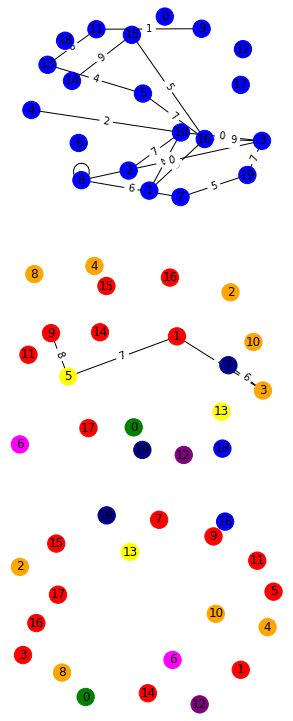

In [415]:
# TODO: make sure we don't need this
G = nx.Graph() # empty graph
G.add_nodes_from(vertices)
G.add_weighted_edges_from(edges)

# create first rdd for the adjancency list
adj = sc.parallelize(G.adj.items())
adj = adj.map(lambda z: (z[0], [(v, w['weight']) for v,w in z[1].items()]))

n_iterations = 2

f, ax = plt.subplots(n_iterations + 1)
f.set_figheight(13)
f.set_figwidth(5)
color_map = ['blue' for _ in range(len(vertices))]
def color(v):
    colors = ['green', 'red', 'blue', 'orange', 'purple', 'yellow', 'magenta', 'darkblue']
    return colors[v % len(colors)]

for i in range(n_iterations):
    # print the current adjacency list
    print(adj.collect())
    print()
    
    # draw the current graph
    edges = adj.flatMap(lambda z: [(z[0], v, w) for v, w in z[1]]).collect()
    draw_edges(vertices, edges, color_map, ax[i])

    # compute the nearest_neighbor mapping
    nn_local = dict(adj.map(nearest_neighbor).collect())

    # broadcast the closest neighbor mapping
    nn = sc.broadcast(nn_local)

    labeling = adj.map(contract_map(nn))

    L_local = dict(labeling.map(lambda z: (z[1][0], z[0])).collect())
    L = sc.broadcast(L_local)
    
    for u, label in L_local.items():
        color_map[u] = color(L_local[label])
    
    E0 = labeling.flatMap(lambda z: [((z[0], L.value[v]), (z[1][0], v, w)) for v, w in z[1][1] if L.value[v] != z[0]])
    E1 = E0.reduceByKey(reduce)
    adj = E1.map(lambda z: (z[0][0], (z[0][1], z[1][2]))).groupByKey().map(lambda z: (z[0], list(z[1])))
    

# print the current adjacency list
print(adj.collect())
print()
    
# draw the current graph
edges = adj.flatMap(lambda z: [(z[0], v, w) for v, w in z[1]]).collect()
draw_edges(vertices, edges, color_map, ax[n_iterations])